# Lost in the Middle: How Language Models Use Long Contexts


~ Karin Brisker


In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup



In [ ]:
# installations
!pip install farm-haystack
!pip install farm-haystack[faiss]

!pip install transformers
!pip install sentence-transformers
!pip install langchain
!pip install wikipedia

!pip install seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [ ]:
# import libraries
import os
import json
import random
from typing import List
from difflib import SequenceMatcher
from tqdm import tqdm
import numpy as np
from transformers import pipeline
from haystack.schema import Document
from haystack.nodes.retriever import EmbeddingRetriever
from haystack.pipelines import ExtractiveQAPipeline
from haystack.nodes import FARMReader
from haystack.document_stores import FAISSDocumentStore
from sentence_transformers import SentenceTransformer
from pydantic import BaseModel, Field
from langchain.document_loaders import WikipediaLoader

## Model Choices

- **SentenceTransformer("distilbert-base-nli-stsb-mean-tokens"):** This model is a refined version of DistilBERT, fine-tuned to generate sentence embeddings. It retains high performance on NLP tasks while being more compact and quicker than the original BERT model.

- **FAISSDocumentStore(faiss_index_factory_str="Flat"):** FAISS, a library for efficient vector similarity search, is utilized here. The FAISSDocumentStore combines a database and a FAISS index to store and retrieve documents based on their vector embeddings.

- **FARMReader(model_name_or_path="deepset/roberta-base-squad2"):** Tailored for extractive question answering on the SQuAD dataset, this version of RoBERTa has been trained to predict answers within a given context.

- **EmbeddingRetriever(document_store=document_store, embedding_model="sentence-transformers/distilbert-base-nli-stsb-mean-tokens"):** The EmbeddingRetriever retrieves documents from the store based on vector embedding similarity. It employs the aforementioned SentenceTransformer model to generate these embeddings.

- **ExtractiveQAPipeline(reader=reader, retriever=retriever):** Combining the retriever and reader components, this pipeline conducts extractive question answering. The retriever identifies relevant documents in the store, and the reader selects the best answer from these documents.

- **pipeline("question-answering", model="distilbert-base-cased-distilled-squad"):** Another variant of the DistilBERT model, designed for extractive question answering on the SQuAD dataset.


In [ ]:
# Initialize SentenceTransformer model
model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
# adding embedding component
class EmbeddingDocument(Document):
    embedding: list = Field(default_factory=list)
    meta: dict = Field(default_factory=dict)
    id: str
    content_type: str

    def to_dict(self):
        return {
            "content": self.content,
            "metadata": self.meta,
            "embedding": self.embedding,
            "meta": self.meta,
            "content_type": self.content_type,
        }

In [ ]:
# Define a function to determine similarity between strings
def is_similar(string1, string2, threshold=0.8):
  """
  Determines if two strings are similar based on their similarity ratio.

  Args:
      string1 (str): First string for comparison.
      string2 (str): Second string for comparison.
      threshold (float, optional): Similarity threshold. Defaults to 0.8.

  Returns:
      bool: True if the similarity ratio is above the threshold, False otherwise.
  """
  similarity_ratio = SequenceMatcher(None, string1, string2).ratio()
  return similarity_ratio >= threshold

In [ ]:
# Define a function to check answers against ground truth
def check_answer(gt_answers: List[str], prediction: str) -> float:
  """
  Checks if the predicted answer matches any of the ground truth answers.

  Args:
      gt_answers (List[str]): List of ground truth answers.
      prediction (str): Predicted answer.

  Returns:
      float: 1.0 if the prediction matches any ground truth answer, otherwise 0.0.
  """
  for gt in gt_answers:
    if prediction in gt or gt in prediction:
      return 1.0
    elif is_similar(prediction, gt):
      return 1.0
  return 0.0

In [ ]:
# retrieve Wikipedia passages
def wikipedia_passages(query, k):
  """
  Retrieves the top k most relevant Wikipedia passages for a given query.

  Args:
      query (str): Query for retrieving relevant passages.
      k (int): Number of passages to retrieve.

  Returns:
      List[EmbeddingDocument]: List of EmbeddingDocument objects containing relevant passages.
  """
  # Create a Wikipedia loader
  loader = WikipediaLoader(query)

  # Load the Wikipedia dataset
  documents = loader.load()

  # Split the documents into passages of at most 100 tokens
  passages = []
  for document in documents:
      content = document.page_content
      sections = [sec for sec in content.splitlines() if len(sec)>10 and not sec.startswith("=")]
      # print(len(sections))
      for section in sections:
          passage_content = section
          passage = EmbeddingDocument(content=passage_content, metadata=document.metadata, id=str(len(passages)),
                                      content_type="text")
          passage.embedding = model.encode(passage_content)
          passages.append(passage)
          # print(passage)
          # print(len(passages))
          if len(passages) >= k:
            return passages[:k]

## Evaluation

### Accuracy vs. Number of Documents in Input Context - Running QA Pipeline

In [ ]:
file_path = "/content/faiss_document_store.db"
if os.path.exists(file_path):
  os.remove(file_path)

# Load saved answers
with open("saved_answers.json", 'r') as f:
    saved_answers = json.load(f)

# Initialize document store and retriever
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat")
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2")
retriever = EmbeddingRetriever(document_store=document_store, embedding_model="sentence-transformers/distilbert-base-nli-stsb-mean-tokens", use_gpu=False)
extractive_qa_pipeline = ExtractiveQAPipeline(reader=reader, retriever=retriever)
nlp = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

k_vals = [4, 9, 19, 29]
accuracy_by_k = dict.fromkeys(k_vals)
answer_scores = {k: [] for k in k_vals}

# Iterate over saved answers
counter = 1
for qa_tuple in tqdm(saved_answers[:20]):
  print(f"\n\nquestion number: #{counter}\n\n")
  counter += 1
  question, answers, gt_section = qa_tuple["question"], qa_tuple["answers"], qa_tuple["section"]

  documents = wikipedia_passages(question, max(k_vals))
  document_store.write_documents(documents=documents)
  document_store.update_embeddings(retriever)

  gt_section_doc = Document(content=gt_section, meta={}, content_type="text")

  for k in k_vals:
    print(f"k = {k}\n\n")
    documents = extractive_qa_pipeline.run(query=question, params={"Retriever": {"top_k": k}})["documents"]
    print(k, len(documents))

    documents.append(gt_section_doc)
    docs = [doc.content for doc in documents]
    random.shuffle(docs)
    idx = np.random.randint(k + 1)
    docs.insert(idx, gt_section)

    context = "\n\n".join(docs)
    prediction = nlp(question=question, context=context)
    is_correct = check_answer(answers, prediction["answer"])
    print(f'\n{is_correct}:\n{question}\n{prediction["answer"]}\n{answers}\n{"-"*10}')

    answer_scores[k].append(is_correct)

for k in k_vals:
  print(k)
  accuracy = answer_scores[k].count(1.0)/len(answer_scores[k])*100
  accuracy_by_k[k] = accuracy
  print(f"{answer_scores[k].count(1.0)}/{len(answer_scores[k])} = {accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]



question number: #1




Writing Documents: 10000it [00:00, 140197.55it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:11, 839.64 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.73s/ Batches]


4 4

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.13s/ Batches]


9 9

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:24<00:00, 24.44s/ Batches]


19 19

0.0:
when was the last time anyone was on the moon
3 January 2019
['14 December 1972 UTC', 'December 1972']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:28<00:00, 28.26s/ Batches]


29 29


  5%|▌         | 1/20 [01:44<33:08, 104.65s/it]


1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------


question number: #2




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 138767.07it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:06, 1643.39 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.06s/ Batches]


4 4

0.0:
who was the ruler of england in 1616
Álvaro VII
['James I']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.69s/ Batches]


9 9

0.0:
who was the ruler of england in 1616
James VI and I (James Charles Stuart
['James I']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.63s/ Batches]


19 19

0.0:
who was the ruler of england in 1616
Afonso III
['James I']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:27<00:00, 27.30s/ Batches]


29 29


 10%|█         | 2/20 [03:07<27:31, 91.72s/it] 


0.0:
who was the ruler of england in 1616
Álvaro VIII
['James I']
----------


question number: #3




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 109700.89it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:29, 336.54 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.04s/ Batches]


4 4

1.0:
who does the voice of nala in the lion king
Laura Williams and Sally Dworsky
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:12<00:00, 12.37s/ Batches]


9 9

0.0:
who does the voice of nala in the lion king
Ernie Sabella
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:26<00:00, 26.57s/ Batches]


19 19

0.0:
who does the voice of nala in the lion king
Matthew Broderick
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:37<00:00, 37.34s/ Batches]


29 29


 15%|█▌        | 3/20 [06:00<36:31, 128.89s/it]


1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------


question number: #4




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 151071.51it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:15, 660.00 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.54s/ Batches]


4 4

1.0:
who is under the mask of darth vader
Anakin Skywalker
['Anakin Skywalker']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.08s/ Batches]


9 9

0.0:
who is under the mask of darth vader
Palpatine
['Anakin Skywalker']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.69s/ Batches]


19 19

0.0:
who is under the mask of darth vader
Luke
['Anakin Skywalker']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:41<00:00, 41.35s/ Batches]


29 29


 20%|██        | 4/20 [08:18<35:19, 132.46s/it]


0.0:
who is under the mask of darth vader
David Prowse
['Anakin Skywalker']
----------


question number: #5




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 149042.31it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:33, 295.60 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.30s/ Batches]


4 4

1.0:
how many seasons of vampire diaries r there
eight
['eight', '8']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.15s/ Batches]


9 9

1.0:
how many seasons of vampire diaries r there
171 episodes over eight
['eight', '8']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:23<00:00, 23.95s/ Batches]


19 19

1.0:
how many seasons of vampire diaries r there
eight
['eight', '8']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:55<00:00, 55.05s/ Batches]


29 29


 25%|██▌       | 5/20 [11:06<36:18, 145.21s/it]


1.0:
how many seasons of vampire diaries r there
eight
['eight', '8']
----------


question number: #6




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 47911.74it/s]
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:25, 392.51 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.32s/ Batches]


4 4

1.0:
how many episodes are there in dragon ball z
291
['291 episodes', '291']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:23<00:00, 23.45s/ Batches]


9 9

0.0:
how many episodes are there in dragon ball z
69
['291 episodes', '291']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:43<00:00, 43.03s/ Batches]


19 19

0.0:
how many episodes are there in dragon ball z
153
['291 episodes', '291']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:44<00:00, 44.11s/ Batches]


29 29


 30%|███       | 6/20 [14:42<39:30, 169.31s/it]


0.0:
how many episodes are there in dragon ball z
167
['291 episodes', '291']
----------


question number: #7




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 94443.55it/s]
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:51, 193.54 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.61s/ Batches]


4 4

1.0:
when was the first australian prime minister elected
1 January 1901
['Sir Edmund Barton', '1901']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:22<00:00, 22.05s/ Batches]


9 9

0.0:
when was the first australian prime minister elected
1939–1941
['Sir Edmund Barton', '1901']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:50<00:00, 50.83s/ Batches]


19 19

0.0:
when was the first australian prime minister elected
1939–1941
['Sir Edmund Barton', '1901']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:39<00:00, 39.52s/ Batches]


29 29


 35%|███▌      | 7/20 [18:33<41:04, 189.56s/it]


1.0:
when was the first australian prime minister elected
1 January 1901
['Sir Edmund Barton', '1901']
----------


question number: #8




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 161075.91it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:17, 560.86 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.26s/ Batches]


4 4

1.0:
who plays joker in batman the dark knight
Heath Ledger
['Ledger']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:10<00:00, 10.81s/ Batches]


9 9

1.0:
who plays joker in batman the dark knight
Heath Ledger
['Ledger']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.57s/ Batches]


19 19

1.0:
who plays joker in batman the dark knight
Heath Ledger
['Ledger']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:50<00:00, 50.88s/ Batches]


29 29


 40%|████      | 8/20 [20:57<34:59, 174.94s/it]


1.0:
who plays joker in batman the dark knight
Ledger
['Ledger']
----------


question number: #9




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 149983.52it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:33, 296.33 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.80s/ Batches]


4 4

0.0:
when was the south asian association for regional co-operation (saarc) formed
2006
['December 1985', '8 December 1985']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.15s/ Batches]


9 9

1.0:
when was the south asian association for regional co-operation (saarc) formed
1985
['December 1985', '8 December 1985']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:23<00:00, 23.45s/ Batches]


19 19

1.0:
when was the south asian association for regional co-operation (saarc) formed
1985
['December 1985', '8 December 1985']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:30<00:00, 30.96s/ Batches]


29 29


 45%|████▌     | 9/20 [23:05<29:25, 160.46s/it]


1.0:
when was the south asian association for regional co-operation (saarc) formed
1985
['December 1985', '8 December 1985']
----------


question number: #10




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 150685.62it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:25, 397.41 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.21s/ Batches]


4 4

0.0:
when was the first hunger games book published
2012
['September 14, 2008', '2008']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.12s/ Batches]


9 9

1.0:
when was the first hunger games book published
September 14, 2008
['September 14, 2008', '2008']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.05s/ Batches]


19 19

0.0:
when was the first hunger games book published
2012
['September 14, 2008', '2008']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:33<00:00, 33.52s/ Batches]


29 29


 50%|█████     | 10/20 [25:29<25:54, 155.41s/it]


1.0:
when was the first hunger games book published
September 1, 2009
['September 14, 2008', '2008']
----------


question number: #11




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 109779.57it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:33, 294.69 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.43s/ Batches]


4 4

1.0:
who is the lead singer of depeche mode
Dave Gahan
['David Gahan']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.29s/ Batches]


9 9

0.0:
who is the lead singer of depeche mode
Martin Gore
['David Gahan']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:30<00:00, 30.56s/ Batches]


19 19

1.0:
who is the lead singer of depeche mode
Dave Gahan
['David Gahan']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:44<00:00, 44.16s/ Batches]


29 29


 55%|█████▌    | 11/20 [28:19<23:56, 159.61s/it]


1.0:
who is the lead singer of depeche mode
Dave Gahan
['David Gahan']
----------


question number: #12




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 147716.93it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:26, 376.96 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.78s/ Batches]


4 4

1.0:
who developed the concept of total quality management
W. Edwards Deming
['W. Edwards Deming']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.91s/ Batches]


9 9

1.0:
who developed the concept of total quality management
W. Edwards Deming
['W. Edwards Deming']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:19<00:00, 19.01s/ Batches]


19 19

1.0:
who developed the concept of total quality management
W. Edwards Deming
['W. Edwards Deming']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:30<00:00, 30.10s/ Batches]


29 29


 60%|██████    | 12/20 [30:23<19:51, 148.93s/it]


0.0:
who developed the concept of total quality management
Walter A. Shewhart
['W. Edwards Deming']
----------


question number: #13




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 104141.88it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:28, 355.17 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.24s/ Batches]


4 4

1.0:
who wrote cant get you out of my head lyrics
Cathy Dennis and Rob Davis
['Cathy Dennis and Rob Davis', 'Rob Davis', 'Cathy Dennis']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:11<00:00, 11.40s/ Batches]


9 9

1.0:
who wrote cant get you out of my head lyrics
Dennis
['Cathy Dennis and Rob Davis', 'Rob Davis', 'Cathy Dennis']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.61s/ Batches]


19 19

1.0:
who wrote cant get you out of my head lyrics
Dennis
['Cathy Dennis and Rob Davis', 'Rob Davis', 'Cathy Dennis']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:36<00:00, 36.21s/ Batches]


29 29


 65%|██████▌   | 13/20 [32:44<17:05, 146.49s/it]


0.0:
who wrote cant get you out of my head lyrics
Mick Jagger
['Cathy Dennis and Rob Davis', 'Rob Davis', 'Cathy Dennis']
----------


question number: #14




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 102733.83it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:34, 286.88 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.28s/ Batches]


4 4

1.0:
when did taylor swift's first album release
October 24, 2006
['October 24, 2006', '2005']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:13<00:00, 13.25s/ Batches]


9 9

1.0:
when did taylor swift's first album release
October 27, 2023
['October 24, 2006', '2005']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:25<00:00, 25.72s/ Batches]


19 19

1.0:
when did taylor swift's first album release
October 24, 2006
['October 24, 2006', '2005']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:36<00:00, 36.38s/ Batches]


29 29


 70%|███████   | 14/20 [35:25<15:04, 150.77s/it]


1.0:
when did taylor swift's first album release
October 24, 2006
['October 24, 2006', '2005']
----------


question number: #15




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 147474.38it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:14, 673.82 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.36s/ Batches]


4 4

1.0:
what are the three fifty shades of grey books
Fifty Shades Darker and Fifty Shades Freed
['Fifty Shades of Grey', 'Fifty Shades Darker', 'Fifty Shades Freed']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:10<00:00, 10.43s/ Batches]


9 9

1.0:
what are the three fifty shades of grey books
Fifty Shades Darker, and Fifty Shades Freed
['Fifty Shades of Grey', 'Fifty Shades Darker', 'Fifty Shades Freed']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.67s/ Batches]


19 19

0.0:
what are the three fifty shades of grey books
Tess of the d'Urbervilles
['Fifty Shades of Grey', 'Fifty Shades Darker', 'Fifty Shades Freed']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:28<00:00, 28.84s/ Batches]


29 29


 75%|███████▌  | 15/20 [37:13<11:29, 137.93s/it]


1.0:
what are the three fifty shades of grey books
Fifty Shades of Grey (2015) and Fifty Shades Darker
['Fifty Shades of Grey', 'Fifty Shades Darker', 'Fifty Shades Freed']
----------


question number: #16




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 141618.60it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:14, 687.86 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.99s/ Batches]


4 4

0.0:
who has the power (judicial) to make decisions in courts of law
The system of courts that interprets and applies the law
['judges']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.16s/ Batches]


9 9

0.0:
who has the power (judicial) to make decisions in courts of law
jūdex
['judges']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:19<00:00, 19.32s/ Batches]


19 19

0.0:
who has the power (judicial) to make decisions in courts of law
Parliament
['judges']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:33<00:00, 33.99s/ Batches]


29 29


 80%|████████  | 16/20 [39:12<08:49, 132.39s/it]


0.0:
who has the power (judicial) to make decisions in courts of law
jūdex
['judges']
----------


question number: #17




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 106201.04it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:08, 1137.95 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.77s/ Batches]


4 4

0.0:
what are the ranks in the us navy
officers have various ranks
['E-8s senior chief petty officer', 'E-9s master chief petty officer']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.64s/ Batches]


9 9

0.0:
what are the ranks in the us navy
seaman, fireman, airman, constructionman, or hospitalman
['E-8s senior chief petty officer', 'E-9s master chief petty officer']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.66s/ Batches]


19 19

0.0:
what are the ranks in the us navy
line officers and staff corps
['E-8s senior chief petty officer', 'E-9s master chief petty officer']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:27<00:00, 27.73s/ Batches]


29 29


 85%|████████▌ | 17/20 [40:59<06:14, 124.68s/it]


0.0:
what are the ranks in the us navy
Chief Warrant Officer" and "Master Warrant Officer"
['E-8s senior chief petty officer', 'E-9s master chief petty officer']
----------


question number: #18




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 123259.65it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:27, 367.94 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:04<00:00,  4.80s/ Batches]


4 4

0.0:
when is the last time the vikings were in the nfc championship
1998 NFC Championship Game
['1976', '2017/18']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:10<00:00, 10.53s/ Batches]


9 9

0.0:
when is the last time the vikings were in the nfc championship
1997
['1976', '2017/18']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:22<00:00, 22.89s/ Batches]


19 19

0.0:
when is the last time the vikings were in the nfc championship
1997
['1976', '2017/18']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:34<00:00, 34.06s/ Batches]


29 29


 90%|█████████ | 18/20 [43:23<04:20, 130.38s/it]


0.0:
when is the last time the vikings were in the nfc championship
1997
['1976', '2017/18']
----------


question number: #19




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 142394.60it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:17, 569.93 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.33s/ Batches]


4 4

1.0:
what are the colors of the netherlands flag
red-white-blue
['blue', 'white', 'red']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.68s/ Batches]


9 9

1.0:
what are the colors of the netherlands flag
red, white and blue
['blue', 'white', 'red']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:19<00:00, 19.42s/ Batches]


19 19

1.0:
what are the colors of the netherlands flag
red, white and blue
['blue', 'white', 'red']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:31<00:00, 31.06s/ Batches]


29 29


 95%|█████████▌| 19/20 [45:14<02:04, 124.78s/it]


1.0:
what are the colors of the netherlands flag
red, white and blue
['blue', 'white', 'red']
----------


question number: #20




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 155269.83it/s]        
Updating Embedding:   0%|          | 0/29 [00:00<?, ? docs/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:36, 273.34 docs/s]

k = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:05<00:00,  5.34s/ Batches]


4 4

0.0:
where is lord's prayer found in bible
incipit Our Father
['in the Gospel of Luke']
----------
k = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:10<00:00, 10.30s/ Batches]


9 9

1.0:
where is lord's prayer found in bible
Gospel of Luke
['in the Gospel of Luke']
----------
k = 19




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:24<00:00, 24.79s/ Batches]


19 19

0.0:
where is lord's prayer found in bible
printed gospel tracts
['in the Gospel of Luke']
----------
k = 29




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:34<00:00, 34.35s/ Batches]


29 29


100%|██████████| 20/20 [47:52<00:00, 143.63s/it]


0.0:
where is lord's prayer found in bible
printed gospel tracts
['in the Gospel of Luke']
----------
4
13/20 = 65.0
9
11/20 = 55.00000000000001
19
8/20 = 40.0
29
11/20 = 55.00000000000001


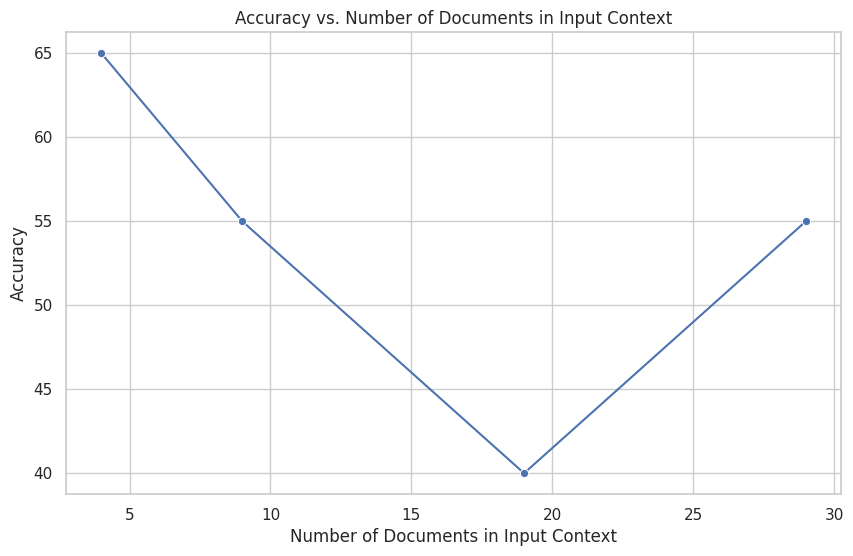

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the data into lists for plotting
documents = list(accuracy_by_k.keys())
accuracy = list(accuracy_by_k.values())

# Create a Seaborn plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=documents, y=accuracy, marker='o')

# Adding labels and title
plt.xlabel("Number of Documents in Input Context")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Documents in Input Context")

# Show the plot
plt.show()

### Accuracy vs. Position of GT in Input Context - Running QA Pipeline

In [ ]:
file_path = "/content/faiss_document_store.db"
if os.path.exists(file_path):
  os.remove(file_path)

# Initialize document store and retriever
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat")
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2")
retriever = EmbeddingRetriever(document_store=document_store, embedding_model="sentence-transformers/distilbert-base-nli-stsb-mean-tokens", use_gpu=False)
extractive_qa_pipeline = ExtractiveQAPipeline(reader=reader, retriever=retriever)
nlp = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

retrieved_docs = 19
positions = [1, 5, 10, 15, 20]
accuracy_by_position = dict.fromkeys(positions)
answer_scores = {pos: [] for pos in positions}

# Iterate over saved answers
counter = 1
for qa_tuple in tqdm(saved_answers[:5]):
  print(f"\n\nquestion number: #{counter}\n\n")
  counter += 1
  question, answers, gt_section = qa_tuple["question"], qa_tuple["answers"], qa_tuple["section"]

  documents = wikipedia_passages(question, 50)
  document_store.write_documents(documents=documents)
  document_store.update_embeddings(retriever)

  gt_section_doc = Document(content=gt_section, meta={}, content_type="text")

  for pos in positions:
    print(f"pos = {pos}\n\n")
    documents = extractive_qa_pipeline.run(query=question, params={"Retriever": {"top_k": retrieved_docs}})["documents"]
    print(retrieved_docs, len(documents))

    documents.append(gt_section_doc)
    docs = [doc.content for doc in documents]
    random.shuffle(docs)
    docs.insert(pos, gt_section)

    context = "\n\n".join(docs)
    prediction = nlp(question=question, context=context)
    is_correct = check_answer(answers, prediction["answer"])
    print(f'\n{is_correct}:\n{question}\n{prediction["answer"]}\n{answers}\n{"-"*10}')

    answer_scores[pos].append(is_correct)

for pos in positions:
  print(pos)
  accuracy = answer_scores[pos].count(1.0)/len(answer_scores[pos])*100
  accuracy_by_position[pos] = accuracy
  print(f"{answer_scores[pos].count(1.0)}/{len(answer_scores[pos])} = {accuracy}")

  0%|          | 0/5 [00:00<?, ?it/s]



question number: #1




Writing Documents: 10000it [00:00, 95361.72it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:38, 256.51 docs/s]

pos = 1




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:25<00:00, 25.02s/ Batches]


19 19

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
pos = 5




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.82s/ Batches]


19 19

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
pos = 10




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.68s/ Batches]


19 19

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
pos = 15




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.66s/ Batches]


19 19

0.0:
when was the last time anyone was on the moon
1976
['14 December 1972 UTC', 'December 1972']
----------
pos = 20




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.21s/ Batches]


19 19


 20%|██        | 1/5 [03:23<13:32, 203.10s/it]


0.0:
when was the last time anyone was on the moon
1976
['14 December 1972 UTC', 'December 1972']
----------


question number: #2




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 102679.76it/s]        
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:05, 1720.99 docs/s]

pos = 1




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:19<00:00, 19.67s/ Batches]


19 19

0.0:
who was the ruler of england in 1616
Nebanfor
['James I']
----------
pos = 5




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:17<00:00, 17.76s/ Batches]


19 19

0.0:
who was the ruler of england in 1616
Garcia II
['James I']
----------
pos = 10




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.34s/ Batches]


19 19

1.0:
who was the ruler of england in 1616
James
['James I']
----------
pos = 15




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.49s/ Batches]


19 19

0.0:
who was the ruler of england in 1616
King
['James I']
----------
pos = 20




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.14s/ Batches]


19 19


 40%|████      | 2/5 [05:21<07:40, 153.41s/it]


0.0:
who was the ruler of england in 1616
Kulashingo
['James I']
----------


question number: #3




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 69129.09it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:33, 298.09 docs/s]

pos = 1




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.21s/ Batches]


19 19

1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
pos = 5




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.30s/ Batches]


19 19

1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
pos = 10




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.47s/ Batches]


19 19

1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
pos = 15




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.38s/ Batches]


19 19

1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
pos = 20




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:33<00:00, 33.86s/ Batches]


19 19


 60%|██████    | 3/5 [09:24<06:28, 194.18s/it]


1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------


question number: #4




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 69537.68it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:58, 172.23 docs/s]

pos = 1




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.39s/ Batches]


19 19

0.0:
who is under the mask of darth vader
Palpatine
['Anakin Skywalker']
----------
pos = 5




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.44s/ Batches]


19 19

0.0:
who is under the mask of darth vader
Darth Vader
['Anakin Skywalker']
----------
pos = 10




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:28<00:00, 28.58s/ Batches]


19 19

0.0:
who is under the mask of darth vader
David Charles Prowse
['Anakin Skywalker']
----------
pos = 15




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.23s/ Batches]


19 19

0.0:
who is under the mask of darth vader
Darth Vader
['Anakin Skywalker']
----------
pos = 20




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.53s/ Batches]


19 19


 80%|████████  | 4/5 [13:33<03:36, 216.04s/it]


0.0:
who is under the mask of darth vader
Obi-Wan Kenobi
['Anakin Skywalker']
----------


question number: #5




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 72210.13it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:29, 343.49 docs/s]

pos = 1




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.52s/ Batches]


19 19

1.0:
how many seasons of vampire diaries r there
8
['eight', '8']
----------
pos = 5




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.45s/ Batches]


19 19

1.0:
how many seasons of vampire diaries r there
eight
['eight', '8']
----------
pos = 10




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:18<00:00, 18.09s/ Batches]


19 19

1.0:
how many seasons of vampire diaries r there
8
['eight', '8']
----------
pos = 15




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.98s/ Batches]


19 19

0.0:
how many seasons of vampire diaries r there
three
['eight', '8']
----------
pos = 20




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:24<00:00, 24.80s/ Batches]


19 19


100%|██████████| 5/5 [16:36<00:00, 199.27s/it]


1.0:
how many seasons of vampire diaries r there
8
['eight', '8']
----------
1
3/5 = 60.0
5
3/5 = 60.0
10
4/5 = 80.0
15
1/5 = 20.0
20
2/5 = 40.0


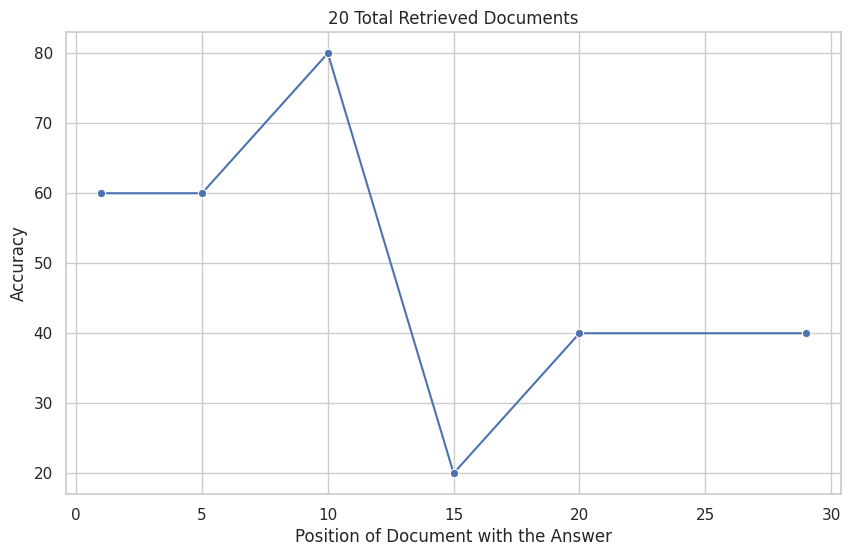

In [ ]:
# Convert the data into lists for plotting
documents = list(accuracy_by_position.keys())
accuracy = list(accuracy_by_position.values())

# Create a Seaborn plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=documents, y=accuracy, marker='o')

# Adding labels and title
plt.xlabel("Position of Document with the Answer")
plt.ylabel("Accuracy")
plt.title("20 Total Retrieved Documents")

# Show the plot
plt.show()

In [ ]:
file_path = "/content/faiss_document_store.db"
if os.path.exists(file_path):
  os.remove(file_path)

# Load saved answers
with open("saved_answers.json", 'r') as f:
    saved_answers = json.load(f)

# Initialize document store and retriever
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat")
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2")
retriever = EmbeddingRetriever(document_store=document_store, embedding_model="sentence-transformers/distilbert-base-nli-stsb-mean-tokens", use_gpu=False)
extractive_qa_pipeline = ExtractiveQAPipeline(reader=reader, retriever=retriever)
nlp = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

retrieved_docs = 9
positions = [0, 4, 9]
accuracy_by_position = dict.fromkeys(positions)
answer_scores = {pos: [] for pos in positions}

# Iterate over saved answers
counter = 1
for qa_tuple in tqdm(saved_answers[:5]):
  print(f"\n\nquestion number: #{counter}\n\n")
  counter += 1
  question, answers, gt_section = qa_tuple["question"], qa_tuple["answers"], qa_tuple["section"]

  documents = wikipedia_passages(question, 50)
  document_store.write_documents(documents=documents)
  document_store.update_embeddings(retriever)

  gt_section_doc = Document(content=gt_section, meta={}, content_type="text")

  for pos in positions:
    print(f"pos = {pos}\n\n")
    documents = extractive_qa_pipeline.run(query=question, params={"Retriever": {"top_k": retrieved_docs}})["documents"]
    print(retrieved_docs, len(documents))

    documents.append(gt_section_doc)
    docs = [doc.content for doc in documents]
    random.shuffle(docs)
    docs.insert(pos, gt_section)

    context = "\n\n".join(docs)
    prediction = nlp(question=question, context=context)
    is_correct = check_answer(answers, prediction["answer"])
    print(f'\n{is_correct}:\n{question}\n{prediction["answer"]}\n{answers}\n{"-"*10}')

    answer_scores[pos].append(is_correct)

for pos in positions:
  print(pos)
  accuracy = answer_scores[pos].count(1.0)/len(answer_scores[pos])*100
  accuracy_by_position[pos] = accuracy
  print(f"{answer_scores[pos].count(1.0)}/{len(answer_scores[pos])} = {accuracy}")

  0%|          | 0/5 [00:00<?, ?it/s]



question number: #1




Writing Documents: 10000it [00:00, 66013.88it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:36, 276.07 docs/s]

pos = 0




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.80s/ Batches]


9 9

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
pos = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:06<00:00,  6.36s/ Batches]


9 9

1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------
pos = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:08<00:00,  8.28s/ Batches]


9 9


 20%|██        | 1/5 [01:28<05:52, 88.01s/it]


1.0:
when was the last time anyone was on the moon
December 1972
['14 December 1972 UTC', 'December 1972']
----------


question number: #2




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 29401.73it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:08, 1129.81 docs/s]

pos = 0




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:13<00:00, 13.11s/ Batches]


9 9

0.0:
who was the ruler of england in 1616
James VI and I (James Charles Stuart
['James I']
----------
pos = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.26s/ Batches]


9 9

0.0:
who was the ruler of england in 1616
Barbara
['James I']
----------
pos = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.51s/ Batches]


9 9


 40%|████      | 2/5 [02:36<03:50, 76.72s/it]


0.0:
who was the ruler of england in 1616
Barbara
['James I']
----------


question number: #3




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 85550.55it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:40, 246.11 docs/s]

pos = 0




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:11<00:00, 11.85s/ Batches]


9 9

1.0:
who does the voice of nala in the lion king
Moira Kelly
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
pos = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:07<00:00,  7.01s/ Batches]


9 9

0.0:
who does the voice of nala in the lion king
Ernie Sabella
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------
pos = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:08<00:00,  8.59s/ Batches]


9 9


 60%|██████    | 3/5 [04:24<03:02, 91.08s/it]


1.0:
who does the voice of nala in the lion king
Laura Williams and Sally Dworsky
['Niketa Calame', 'Sally Dworsky', 'Moira Kelly', 'Laura Williams']
----------


question number: #4




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 58319.99it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [01:08, 145.95 docs/s]

pos = 0




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:08<00:00,  8.13s/ Batches]


9 9

0.0:
who is under the mask of darth vader
Obi-Wan Kenobi
['Anakin Skywalker']
----------
pos = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.47s/ Batches]


9 9

0.0:
who is under the mask of darth vader
Darth Vader
['Anakin Skywalker']
----------
pos = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:13<00:00, 13.55s/ Batches]


9 9


 80%|████████  | 4/5 [06:57<01:55, 115.47s/it]


0.0:
who is under the mask of darth vader
Obi-Wan Kenobi
['Anakin Skywalker']
----------


question number: #5




Please call `update_embeddings` method to correctly repopulate `faiss_index`
Writing Documents: 10000it [00:00, 60770.19it/s]
Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Documents Processed: 10000 docs [00:46, 212.91 docs/s]

pos = 0




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:14<00:00, 14.58s/ Batches]


9 9

1.0:
how many seasons of vampire diaries r there
8
['eight', '8']
----------
pos = 4




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:08<00:00,  8.90s/ Batches]


9 9

1.0:
how many seasons of vampire diaries r there
8
['eight', '8']
----------
pos = 9




Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Inferencing Samples: 100%|██████████| 1/1 [00:09<00:00,  9.19s/ Batches]


9 9


100%|██████████| 5/5 [08:50<00:00, 106.14s/it]


1.0:
how many seasons of vampire diaries r there
eight
['eight', '8']
----------
0
3/5 = 60.0
4
2/5 = 40.0
9
3/5 = 60.0


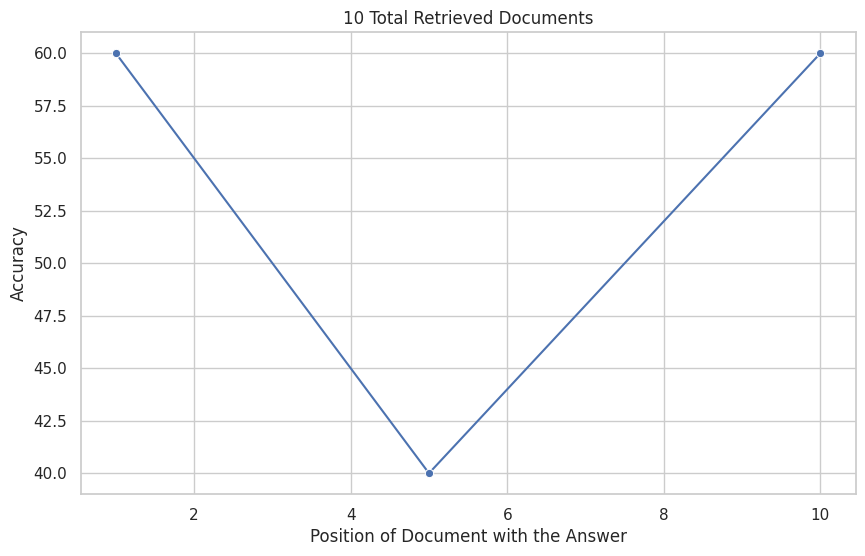

In [ ]:
# Convert the data into lists for plotting
documents = list([k+1 for k in accuracy_by_position.keys()])
accuracy = list(accuracy_by_position.values())

# Create a Seaborn plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=documents, y=accuracy, marker='o')

# Adding labels and title
plt.xlabel("Position of Document with the Answer")
plt.ylabel("Accuracy")
plt.title("10 Total Retrieved Documents")

# Show the plot
plt.show()